In [1]:
import glob
import sys
import matplotlib.pyplot as plt
import numpy as np

import lmfit
from lmfit import Parameters, fit_report, Minimizer
import corner
from astropy.coordinates import SkyCoord

from astropy.time import Time
import astropy.units as u

# Fitting annual variations of arc curvatures or velocities

This was largely based on 'scintools' by Daniel Reardon, which also has nice examples, and demonstration of a full annual+orbital solution:  https://github.com/danielreardon/scintools

In [2]:
def get_earth_velocity(mjds, coord):
    """
    Calculates the component of Earth's velocity transverse to the line of
    sight, in RA and DEC
    """

    from astropy.time import Time
    from astropy.coordinates import get_body_barycentric_posvel
    from astropy import units as u
    from astropy.constants import au

    rarad = coord.ra.value * np.pi/180
    decrad = coord.dec.value * np.pi/180

    vearth_ra = []
    vearth_dec = []
    for mjd in mjds:
        time = Time(mjd, format='mjd')
        pos_xyz, vel_xyz = get_body_barycentric_posvel('earth', time)

        vx = vel_xyz.x.value
        vy = vel_xyz.y.value
        vz = vel_xyz.z.value

        vearth_ra.append(- vx * np.sin(rarad) + vy * np.cos(rarad))
        vearth_dec.append(- vx * np.sin(decrad) * np.cos(rarad) -
                          vy * np.sin(decrad) * np.sin(rarad) +
                          vz * np.cos(decrad))

    # Convert from AU/d to km/s
    vearth_ra = vearth_ra * au/1e3/86400
    vearth_dec = vearth_dec * au/1e3/86400

    return vearth_ra.value.squeeze(), vearth_dec.value.squeeze()


def effective_velocity_annual(params, vearth_ra, vearth_dec):
    """
    Effective velocity with annual and pulsar terms
        Note: Does NOT include IISM velocity, but returns veff in IISM frame
    """
    # Define some constants
    v_c = 299792.458  # km/s
    kmpkpc = 3.085677581e16
    secperyr = 86400*365.2425
    masrad = np.pi/(3600*180*1000)

    # tempo2 parameters from par file in capitals
    vp_x = 0
    vp_y = 0

    if 'PMRA' in params.keys():
        PMRA = params['PMRA']  # proper motion in RA
        PMDEC = params['PMDEC']  # proper motion in DEC
    else:
        PMRA = 0
        PMDEC = 0

    # other parameters in lower-case
    d = params['d']  # pulsar distance in kpc
    if 's' in params.keys():
        s = params['s']  # fractional screen distance
    elif 'd_s' in params.keys():
        d_s = params['d_s'] # screen distance in kpc
        s = 1 - d_s / d
    else:
        print('Warning: need either s or d_s')        
    d = d * kmpkpc  # distance in km

    pmra_v = PMRA * masrad * d / secperyr
    pmdec_v = PMDEC * masrad * d / secperyr

    # find total effective velocity in RA and DEC
    veff_ra = s * vearth_ra + (1 - s) * (pmra_v)
    veff_dec = s * vearth_dec + (1 - s) * (pmdec_v)

    return veff_ra, veff_dec


def arc_curvature(params, ydata, weights,
                  vearth_ra, vearth_dec, vfit=False, modelonly=False):
    """
    arc curvature model

        ydata: arc curvature (when vfit=False), or 
               1.e3 / sqrt(arc curvature) (when vfit=True)
    """

    kmpkpc = 3.085677581e16

    # Other parameters in lower-case
    d = params['d']  # pulsar distance in kpc
    if 's' in params.keys():
        s = params['s']  # fractional screen distance
    elif 'd_s' in params.keys():
        d_s = params['d_s'] # screen distance in kpc
        s = 1 - d_s / d
    else:
        print('Warning: need either s or d_s') 
    dkm = d * kmpkpc  # kms

    veff_ra, veff_dec = \
        effective_velocity_annual(params, vearth_ra, vearth_dec)

    if 'nmodel' in params.keys():
        nmodel = params['nmodel']
    else:
        if 'psi' in params.keys():
            nmodel = 1
        else:
            nmodel = 0

    if 'vism_ra' in params.keys():
        vism_ra = params['vism_ra']
        vism_dec = params['vism_dec']
    else:
        vism_ra = 0
        vism_dec = 0

    if nmodel > 0.5:  # anisotropic
        psi = params['psi'] * np.pi / 180  # anisotropy angle
        if 'vism_psi' in params.keys():  # anisotropic case
            vism_psi = params['vism_psi']  # vism in direction of anisotropy
            veff2 = (veff_ra*np.sin(psi) + veff_dec*np.cos(psi) - vism_psi)**2
        else:
            veff2 = ((veff_ra - vism_ra) * np.sin(psi) +
                     (veff_dec - vism_dec) * np.cos(psi)) ** 2
    else:  # isotropic
        veff2 = (veff_ra - vism_ra)**2 + (veff_dec - vism_dec)**2

    # Calculate curvature model
    model = dkm * s * (1 - s)/(2 * veff2)  # in 1/(km * Hz**2)
    # Convert to 1/(m * mHz**2) for beta in 1/m and fdop in mHz
    model = model/1e9

    if weights is None:
        weights = np.ones(np.shape(ydata))

    if vfit:
        model = 1e3 / np.sqrt(model)

    if modelonly:
        return model

    return (ydata - model) * weights

In [8]:
# read results and set parameter arrays
data = np.loadtxt('data/J1643_V.txt')

source = SkyCoord.from_name('PSR J1643-1224')
ra = source.ra.to(u.deg).value
dec = source.dec.to(u.deg).value

mjd = data[:,0]
veff = data[:,1]
vefferr = data[:,2]

# vfit = 1 to fit 1 / sqrt(eta), proportional to v_eff
vfit = 1
anisotropy = False

if vfit:
    y = np.copy(veff)
    yerr = np.copy(vefferr)
else:
    y = np.copy(eta)
    yerr = np.copy(etaerr)

print('Getting Earth velocity')
vearth_ra, vearth_dec = get_earth_velocity(mjd, source)

params = Parameters()

# Pulsar distance and proper motion of J1643-1224 hardcoded
# PM in mas/yr, D in kpc
pmra_0 = 6.10
pmdec_0 = -4.39
D_0 = 0.85
params.add('d', value=D_0, vary=False)  # psr distance in kpc 
params.add('d_s', value=D_0/5.,
           vary=True, min=0.0, max=D_0)


params.add('PMRA', value=pmra_0, vary=False)
params.add('PMDEC', value=pmdec_0, vary=False)

if anisotropy:
    params.add('vism_psi', value=0,
               vary=True, min=-1000, max=1000)
    params.add('psi', value=0,
               vary=True, min=0, max=180)
else:
    params.add('vism_ra', value=0,
               vary=True, min=-200, max=200)
    params.add('vism_dec', value=0,
               vary=True, min=-200, max=200)

func = Minimizer(arc_curvature, params,
                 fcn_args=(y, 1/yerr,
                           vearth_ra, vearth_dec, vfit))
  
results = func.minimize()
pfit = results.params


OSError: data/J1643_V.txt not found.

Doing mcmc posterior sample
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 40
    # variables        = 3
    chi-square         = 57.8277049
    reduced chi-square = 1.56291094
    Akaike info crit   = 20.7435412
    Bayesian info crit = 25.8101796
[[Variables]]
    d:         0.85 (fixed)
    d_s:       0.19383455 +/- 0.00830267 (4.28%) (init = 0.1927083)
    PMRA:      6.1 (fixed)
    PMDEC:    -4.39 (fixed)
    vism_ra:   6.80001205 +/- 0.59759488 (8.79%) (init = 6.748548)
    vism_dec: -17.8175081 +/- 0.65233547 (3.66%) (init = -17.75092)
[[Correlations]] (unreported correlations are < 0.100)
    C(d_s, vism_dec)     = -0.857
    C(d_s, vism_ra)      =  0.743
    C(vism_ra, vism_dec) = -0.435


Text(0, 0.5, '$1 / \\sqrt{\\eta}$')

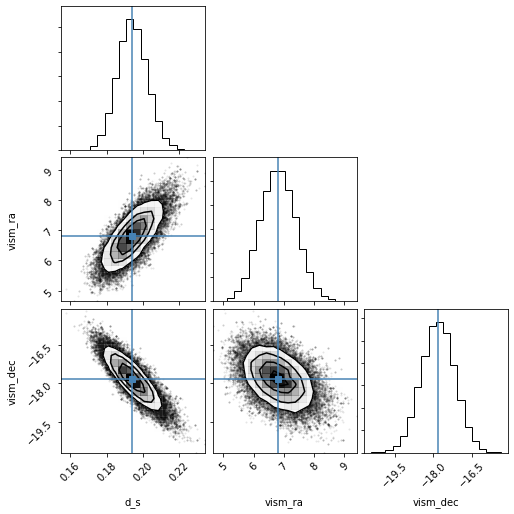

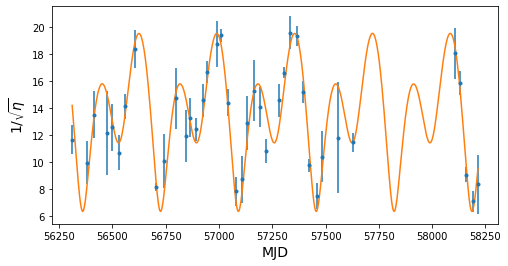

In [6]:
func = Minimizer(arc_curvature, pfit,
                 fcn_args=(y, 1/yerr, vearth_ra, vearth_dec, vfit))

print('Doing mcmc posterior sample')    
mcmc_results = func.emcee(steps=1000, burn=300, nwalkers=100)
mcmc_unchanged = mcmc_results

truths = []
for var in mcmc_results.var_names:
    truths.append(mcmc_results.params[var].value)
labels = mcmc_results.var_names
corner.corner(mcmc_results.flatchain,
              labels=labels,
              truths=truths)
lmfit.report_fit(mcmc_results)

"""
Now plot the fit
"""
mjdrange = np.linspace(mjd[0], mjd[-1], 1000)
vearth_ra_smooth, vearth_dec_smooth = get_earth_velocity(mjdrange, source)


curvature_model = arc_curvature(mcmc_results.params, y, yerr, 
                                vearth_ra_smooth, vearth_dec_smooth,
                                vfit, modelonly=True)                              


plt.figure(figsize=(8,4))
plt.errorbar(mjd, y, yerr, fmt='.')
plt.plot(mjdrange, curvature_model)

plt.xlabel('MJD', fontsize=14)
plt.ylabel(r'$1 / \sqrt{\eta}$', fontsize=14)